### LIBRERÍAS

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from feature_engine.encoding import RareLabelEncoder,OneHotEncoder

### FUNCIONES

In [2]:
def data_year(year):
    """Función que almacena la info del año ingresado"""
    path = 'Data/'
    content = os.listdir(path)
    data_list = []
    for folder in content:
        try:
            if folder.index(year) > 0:
                content_l2 = os.listdir(f'{path}{folder}/')
                for folder2 in content_l2:
                    try:
                        if folder2.index('sdem') > 0:
                            path2 = f'{path}{folder}/{folder2}/conjunto_de_datos/'
                            content_l3 = os.listdir(f'{path2}')
                            #print(f'{path2}{content_l3[0]}')
                            data = pd.read_csv(f'{path2}{content_l3[0]}',
                                               encoding='latin',
                                               usecols = ['R_DEF','ENT','PAR_C','SEX','EDA','L_NAC_C','CS_P13_1','CS_P14_C','CS_P16','CS_P17','N_HIJ',
                                                          'E_CON','UR','CLASE1','CLASE2','HRSOCUP','HRSOCUP','INGOCUP']) 
                            # Variables descartadas: 'NAC_ANIO','EMP_PPAL','PER','ZONA'
                            #print('original',len(data), data.shape)
                            data = data[data['R_DEF']==0]
                            # Filtra los datos de interés
                            #print('completo',len(data))
                            data = data[(data['CS_P13_1']==7)|(data['CS_P13_1']==8)|(data['CS_P13_1']==9)]
                            #print('licenciaturas',len(data))
                            data_list.append(data)
                    except:
                        next
        except:
            next
    return pd.concat(data_list)

### EXTRACCIÓN DE LA INFORMACIÓN

In [3]:
data2018 = data_year('2018')

C:\Users\renat\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
data2019 = data_year('2019')

In [5]:
data2020 = data_year('2020')

In [6]:
data = pd.concat([data2018,data2019,data2020],ignore_index=True)

### REVISIÓN DEL DATA SET

In [7]:
data.shape

(473423, 17)

In [8]:
data.columns

Index(['R_DEF', 'ENT', 'PAR_C', 'SEX', 'EDA', 'L_NAC_C', 'CS_P13_1',
       'CS_P14_C', 'CS_P16', 'CS_P17', 'N_HIJ', 'E_CON', 'UR', 'CLASE1',
       'CLASE2', 'HRSOCUP', 'INGOCUP'],
      dtype='object')

In [9]:
data.dtypes

R_DEF         int64
ENT           int64
PAR_C       float64
SEX         float64
EDA         float64
L_NAC_C     float64
CS_P13_1    float64
CS_P14_C     object
CS_P16      float64
CS_P17      float64
N_HIJ       float64
E_CON       float64
UR            int64
CLASE1        int64
CLASE2        int64
HRSOCUP       int64
INGOCUP       int64
dtype: object

In [10]:
data = data.convert_dtypes()

In [11]:
#to_int = ['PAR_C','SEX','L_NAC_C','CS_P13_1','CS_P14_C','CS_P16','CS_P17','N_HIJ','E_CON']
#for col in to_int:
#    data[col] = pd.to_numeric(data[col],downcast='integer',errors= 'coerce')

In [12]:
data.dtypes

R_DEF        Int64
ENT          Int64
PAR_C        Int64
SEX          Int64
EDA          Int64
L_NAC_C      Int64
CS_P13_1     Int64
CS_P14_C    string
CS_P16       Int64
CS_P17       Int64
N_HIJ        Int64
E_CON        Int64
UR           Int64
CLASE1       Int64
CLASE2       Int64
HRSOCUP      Int64
INGOCUP      Int64
dtype: object

### DEFINICIÓN DE VARIABLE OBJETIVO

In [13]:
# Defino campo target
pd.pivot_table(data,index = ['CLASE1','CLASE2'], values = ['HRSOCUP','INGOCUP'], aggfunc = 'mean')

HRSOCUP      INGOCUP
CLASE1 CLASE2                        
1      1       38.635385  6360.559097
       2        0.000000     0.000000
2      3        0.000000     0.000000
       4        0.000000     0.000000

In [14]:
# Clase1:
# 1 PEA, 
# 2 PNEA
# Personas de 12 años y más que durante el periodo de referencia no tuvieron ni realizaron una actividad 
# económica, ni buscaron desempeñar una en el último mes previo al día de la entrevista.
# Clase2: 
#  1 PoblaciÃ³n ocupada
#  2 PoblaciÃ³n desocupada
#  3 Disponibles
#  4 No disponibles
data['TARGET'] = np.where((data['CLASE1'] == 1)&(data['CLASE2'] == 1),1,0)
# 1 Ejerce
# 0 No Ejerce

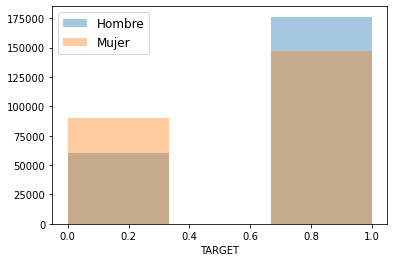

In [15]:
sns.distplot(data[data['SEX']==1]['TARGET'], bins = 3, label='Hombre', kde = False)
sns.distplot(data[data['SEX']==2]['TARGET'], bins = 3, label='Mujer', kde = False)
plt.legend(prop={'size': 12})
plt.show()

In [16]:
#Para evitar colinealidad elimino las 2 columnas que me sirvieron para definir mi columna TARGET
# Aporvecho para eliminar R_DEF que sólo me ayudó a filtrar la info completa
data.drop(['CLASE1','CLASE2', 'R_DEF'], axis=1, inplace=True)

### REVISIÓN DE NULOS

In [17]:
data.isnull().sum()

ENT              0
PAR_C            0
SEX              0
EDA              0
L_NAC_C          0
CS_P13_1         0
CS_P14_C         0
CS_P16           0
CS_P17           0
N_HIJ       236700
E_CON            0
UR               0
HRSOCUP          0
INGOCUP          0
TARGET           0
dtype: int64

In [18]:
# Revisando si hay algún tipo de relación con el parentezco, 
# encontré que la categoría 101, 301, 409 corresponde a "Jefa o jefe, vive sola o solo", "Hija o hijo", "Nieta o nieto" asumiendo que no tienen hijos
# y la categoría 417 corresponden "Nuera o yerno",  
# por lo que se asume que al menos tiene un hijo o hija.
data[data['N_HIJ'].isnull()]['PAR_C'].value_counts()

101    127219
301     81511
201      8399
417      4483
409      4167
403      3290
501      2979
413      2037
418       740
414       523
303       474
401       452
415       143
412       107
421        41
302        35
402        23
419        21
410        20
202        16
999         6
701         5
406         3
423         2
405         1
420         1
422         1
615         1
Name: PAR_C, dtype: Int64

In [19]:
# Asigno un 0 en N_HIJ a los que cumplen con esta característica 
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 101),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 301),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 409),'N_HIJ'] = 0
data.loc[(data['N_HIJ'].isna() == True) & (data['PAR_C'] == 417),'N_HIJ'] = 1

In [20]:
data.isnull().sum()

ENT             0
PAR_C           0
SEX             0
EDA             0
L_NAC_C         0
CS_P13_1        0
CS_P14_C        0
CS_P16          0
CS_P17          0
N_HIJ       19320
E_CON           0
UR              0
HRSOCUP         0
INGOCUP         0
TARGET          0
dtype: int64

In [21]:
# Dado que aún quedaron nulos que no fue posible asignar y que represnetan sólo un 4% del total, decido eliminarlos
data.isnull().sum()['N_HIJ'] / len(data)

0.040809170657107915

In [22]:
data = data.dropna()

### REVISIÓN DE VARIABLES

In [23]:
numerics = ['HRSOCUP','INGOCUP','EDA']
categories = data.drop(['HRSOCUP','INGOCUP','EDA','TARGET'],axis=1).columns

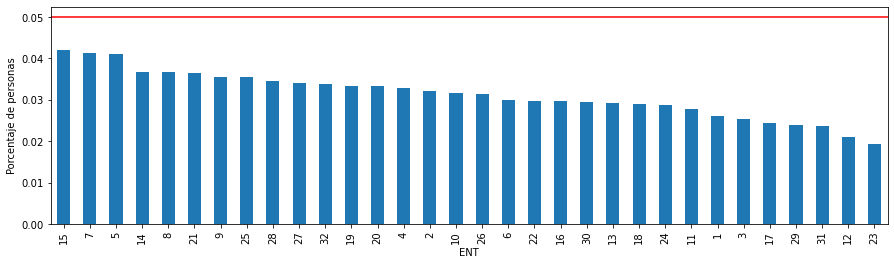

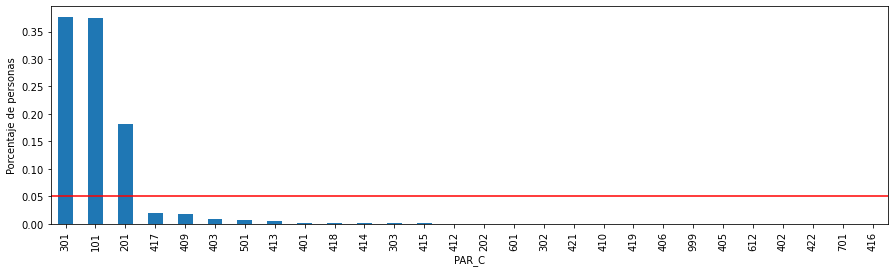

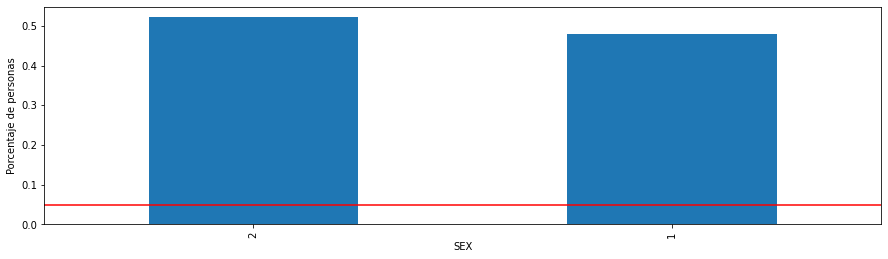

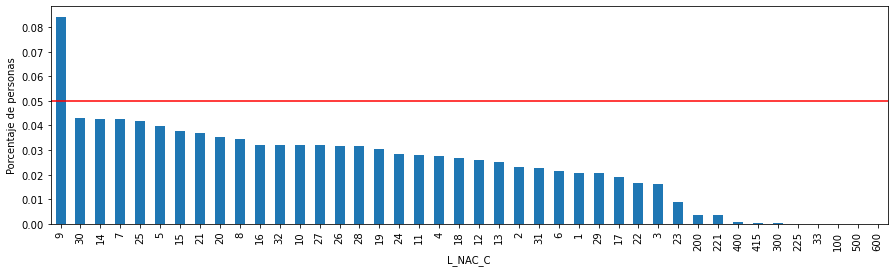

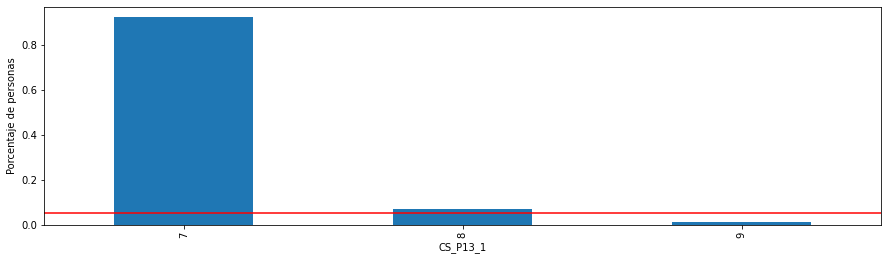

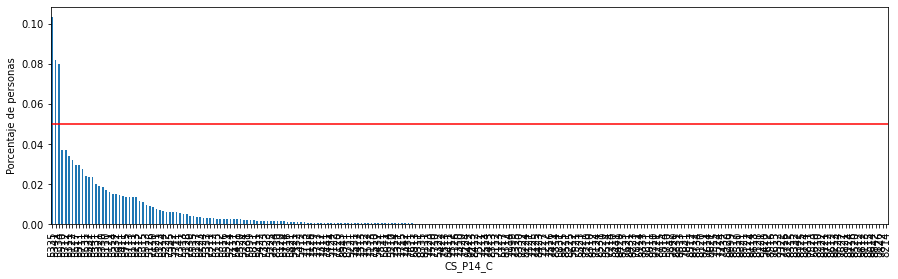

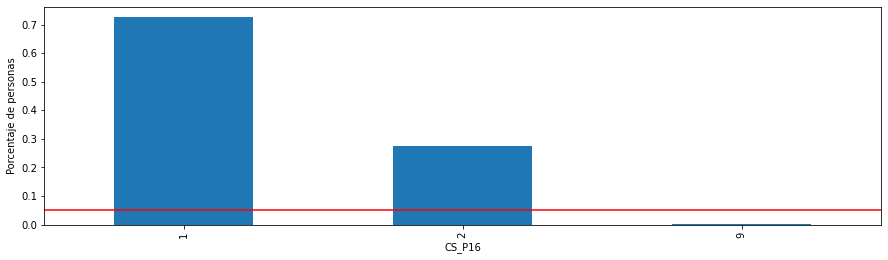

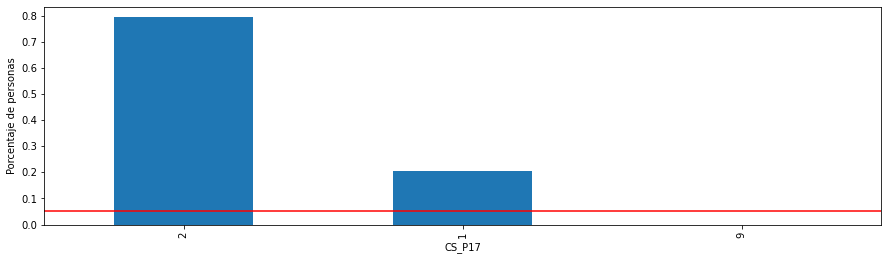

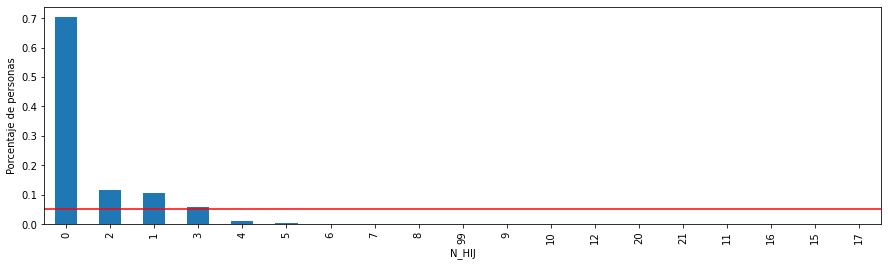

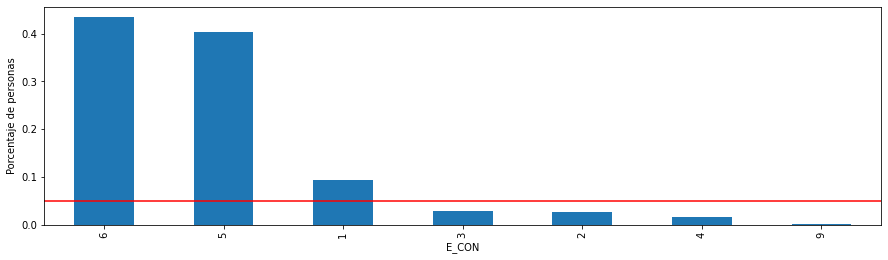

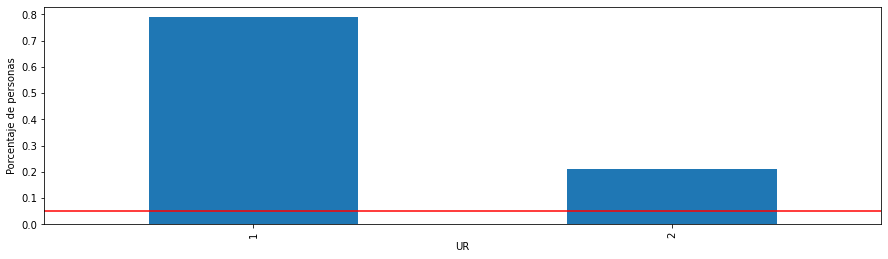

In [24]:
for col in categories:
    temp_df = pd.Series(data[col].value_counts() / len(data))
    plt.figure(figsize = (15,4))
    fig = temp_df.sort_values(ascending = False).plot.bar()
    fig.set_xlabel(col)
    
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Porcentaje de personas')
    plt.show()

In [25]:
# Dado que hay una numerosa cantidad de códigos de carreras, lo reduzco al campo de las mismas
# Genero un diccionario con los campos amplios de las carreras de la Clasificación de Mexicana de Programas de Estudio (CMPE):
carrera = {'1':'Educación', 
           '2':'Artes y humanidades',
           '3':'Ciencias sociales, administración y derecho',
           '4':'Ciencias naturales, exactas y de la computación',
           '5':'Ingeniería, manufactura y construcción',
           '6':'Agronomía y veterinaria',
           '7':'Salud',
           '8':'Servicios',
           '9':'No especificado'}

In [26]:
data['CAMPO'] = pd.to_numeric(data['CS_P14_C'].apply(lambda x: x[1:2]))
#carrera[data.loc[:,'CS_P14_C'][1:2]]
data['CAMPO'].value_counts()

3    199971
5     91880
1     58372
7     47944
4     23677
2     17723
6     11325
8      2171
9      1040
Name: CAMPO, dtype: int64

In [27]:
data.drop('CS_P14_C', axis=1, inplace = True)

In [28]:
# Creación de columna para determinar si la entidad donde se toma la encuesta es la misma que la de nacimiento y determinar si se tuvo que mudar
data['ENT_ORIGEN'] = np.where(data['ENT'] == data['L_NAC_C'], 1, 0)
data['ENT_ORIGEN'].value_counts()

1    358478
0     95625
Name: ENT_ORIGEN, dtype: int64

In [29]:
# Dropeamos las columnas 'ENT' y 'L_NAC_C'
data.drop(['ENT','L_NAC_C'], axis=1, inplace = True)

In [30]:
# EL 99 en la columna N_HIJ implica que no se proporcionó ibnformación por lo que se eliminan estos registros
data = data[data['N_HIJ']!=99]

In [31]:
# Revisión de variables númericas
data[numerics].describe()

,HRSOCUP,INGOCUP,EDA
count,454079.000000,454079.000000,454079.000000
mean,26.190870,4329.077890,37.479271
std,22.725113,7766.034918,14.279818
min,0.000000,0.000000,16.000000
25%,0.000000,0.000000,26.000000
50%,30.000000,0.000000,34.000000
75%,45.000000,7200.000000,47.000000
max,168.000000,300000.000000,98.000000


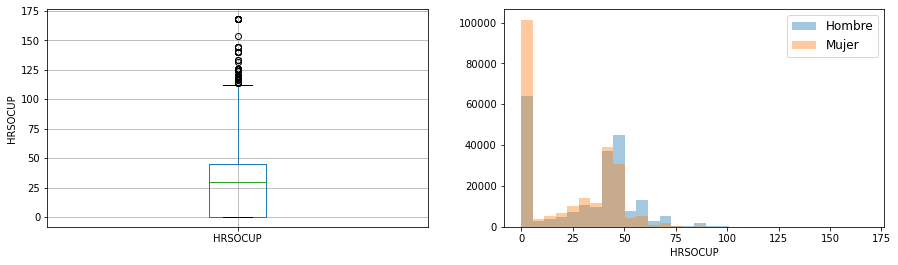

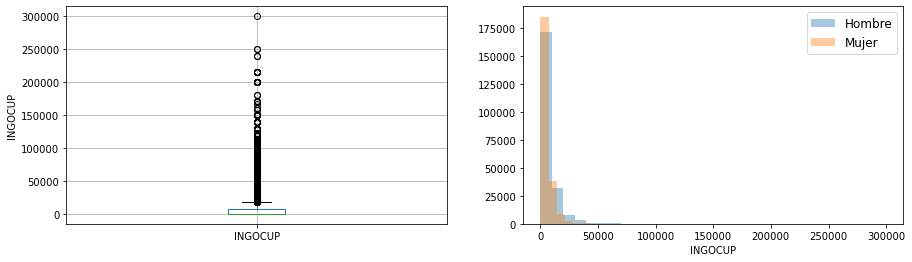

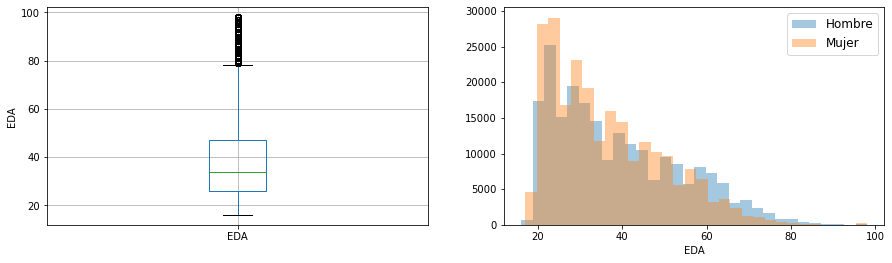

In [32]:
for col in numerics:
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    fig = data.boxplot(column = col)
    fig.set_ylabel(col)
    
    plt.subplot(1,2,2)
    fig = sns.distplot(data[data['SEX']==1][col], bins = 30, label='Hombre', kde = False)
    fig = sns.distplot(data[data['SEX']==2][col], bins = 30, label='Mujer', kde = False) #data[col].hist(bins = 30)
    plt.legend(prop={'size': 12})
    fig.set_xlabel(col)
    plt.show()

In [33]:
# Definimos el rango de edad de interés de los 20 a los 50  y sleccionamos los datos quedndome con el 75% del total del sataset
data_len = len(data)
data = data[(data['EDA']>20)&(data['EDA']<=50)]
len(data)/data_len

0.7493585917868917

### REVISIÓN DE COLINEARIDAD

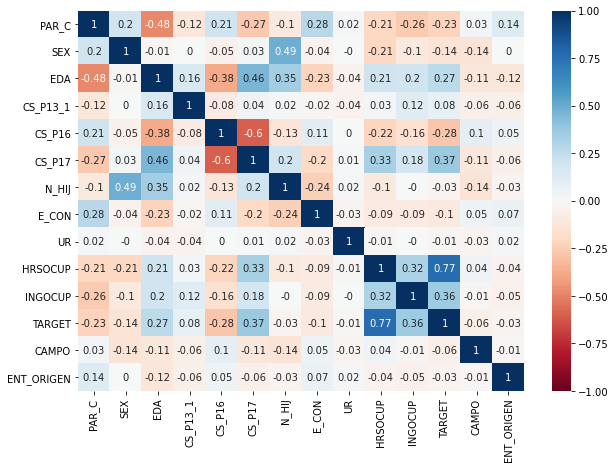

In [34]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr().round(2),  
           vmin = -1,
           vmax = 1,
           cmap = 'RdBu',
           annot =True);
# EMP_ PPAL, no hrs principal sólo con las posibles características

In [35]:
# Dada la alta coreralción de las variables de hora e ingreso, las elimino
data_final = data.drop(['HRSOCUP','INGOCUP'], axis=1)
data_final['N_HIJ'] = data_final['N_HIJ'].astype("object")

In [36]:
X = data_final.drop('TARGET', axis=1) 
y = data_final['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True)
X_train2, X_eval, y_train2, y_eval = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [37]:
X.dtypes

PAR_C          Int64
SEX            Int64
EDA            Int64
CS_P13_1       Int64
CS_P16         Int64
CS_P17         Int64
N_HIJ         object
E_CON          Int64
UR             Int64
CAMPO          int64
ENT_ORIGEN     int32
dtype: object

In [38]:
data_pipeline = Pipeline([('rare_label_enc', RareLabelEncoder(tol=0.05, n_categories=6, variables=['N_HIJ'], replace_with='5')),
                         ('MinMaxScaler', MinMaxScaler())
                        ])

In [39]:
X_train_trans = data_pipeline.fit_transform(X_train)
X_test_trans = data_pipeline.transform(X_test)

### LinearRegression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve,roc_auc_score

In [41]:
lr_model = LogisticRegression()
lr_model.fit(X_train_trans, y_train)

LogisticRegression()

In [42]:
y_pred_test = lr_model.predict(X_test_trans)

In [43]:
confusion_matrix(y_test, y_pred_test)

array([[ 7404, 10376],
       [ 4207, 46067]], dtype=int64)

In [44]:
accuracy_score(y_test, y_pred_test)

0.7857142857142857

0.7673369239156598

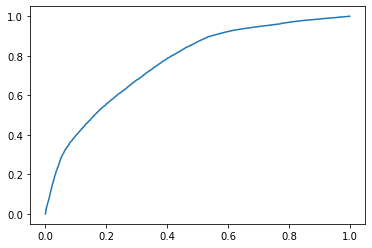

In [45]:
from sklearn import metrics
 
y_pred_proba = lr_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [82]:
# Check overfitting
y_train_pred = lr_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 29242,  41264],
       [ 16381, 185327]], dtype=int64)

In [83]:
accuracy_score(y_train, y_train_pred)

0.788236461019639

### Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf_model = RandomForestClassifier()

RandomForestClassifier()

In [121]:
parameters = {
    'n_estimators': np.arange(10, 300, 150),
    'max_depth': np.arange(6,10,1),
}
gs = GridSearchCV(rf_model, parameters)
gs.fit(X_eval_trans, y_eval)

GridSearchCV(estimator=RandomForestClassifier(max_depth=3, n_estimators=160),
             param_grid={'max_depth': array([6, 7, 8, 9]),
                         'n_estimators': array([ 10, 160])})

In [122]:
gs.best_params_, gs.best_score_

({'max_depth': 9, 'n_estimators': 160}, 0.7978203636808916)

In [123]:
best_params = gs.best_params_
#best_params = {'max_depth': 9, 'n_estimators': 160}

In [124]:
rf_model.set_params(**best_params)
rf_model.fit(X_train_trans, y_train)

RandomForestClassifier(max_depth=9, n_estimators=160)

In [125]:
y_pred_test = rf_model.predict(X_test_trans)

In [126]:
confusion_matrix(y_test, y_pred_test)

array([[ 7227, 10553],
       [ 3360, 46914]], dtype=int64)

In [127]:
accuracy_score(y_test, y_pred_test)

0.795559408704852

0.8003779832077023

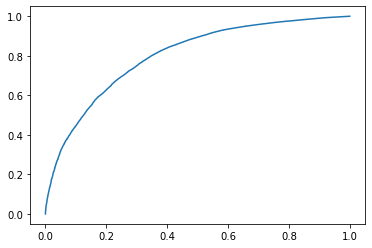

In [128]:
y_pred_proba = rf_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [129]:
# Check overfitting
y_train_pred = rf_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 28650,  41856],
       [ 13144, 188564]], dtype=int64)

In [130]:
accuracy_score(y_train, y_train_pred)

0.7979530810318353

### Gaussian Naive Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB

In [53]:
gnb_model = GaussianNB()
gnb_model.fit(X_train_trans, y_train)

GaussianNB()

In [54]:
y_pred_test = gnb_model.predict(X_test_trans)

In [55]:
confusion_matrix(y_test, y_pred_test)

array([[ 8944,  8836],
       [ 7344, 42930]], dtype=int64)

In [56]:
accuracy_score(y_test, y_pred_test)

0.7622476268845328

0.7436949414844447

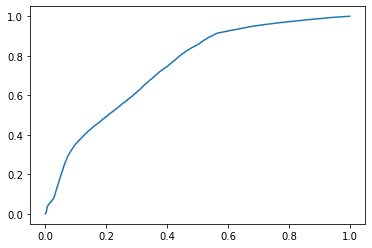

In [57]:
y_pred_proba = gnb_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [86]:
# Check overfitting
y_train_pred = gnb_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 35308,  35198],
       [ 29172, 172536]], dtype=int64)

In [87]:
accuracy_score(y_train, y_train_pred)

0.7635316332003498

### K-Nearest Neighbors

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_trans, y_train)

KNeighborsClassifier()

In [60]:
y_pred_test = knn_model.predict(X_test_trans)

In [61]:
confusion_matrix(y_test, y_pred_test)

array([[ 8263,  9517],
       [ 6029, 44245]], dtype=int64)

In [62]:
accuracy_score(y_test, y_pred_test)

0.7715637581920239

0.7546017453153122

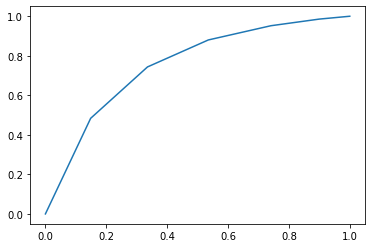

In [63]:
y_pred_proba = knn_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [88]:
# Check overfitting
y_train_pred = knn_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 36424,  34082],
       [ 20743, 180965]], dtype=int64)

In [89]:
accuracy_score(y_train, y_train_pred)

0.7985959575921885

### Gradient Boosting

In [64]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

lgbm_model = LGBMClassifier()

In [66]:
X_eval_trans = data_pipeline.transform(X_eval)

In [69]:
parameters = {
    'learning_rate': np.arange(0.1, 1, 0.1),
    'max_depth':np.arange(4, 10, 1),
    'n_estimators': np.arange(10, 100, 10)}

gs = GridSearchCV(lgbm_model, parameters)
gs.fit(X_eval_trans, y_eval, verbose=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_depth': array([4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])})

In [70]:
gs.best_params_, gs.best_score_

({'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 70},
 0.7980652666380946)

In [78]:
#best_params = gs.best_params_
best_params = {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 70}

In [79]:
# Los seleccionamos y entrenamos un modelo con estos valores
lgbm_model.set_params(**best_params)
lgbm_model.fit(X_train_trans, y_train)

LGBMClassifier(learning_rate=0.2, max_depth=4, n_estimators=70)

In [72]:
y_test_pred = lgbm_model.predict(X_test_trans)

In [73]:
confusion_matrix(y_test, y_test_pred)

array([[ 7409, 10371],
       [ 3549, 46725]], dtype=int64)

In [74]:
accuracy_score(y_test, y_test_pred)

0.7954565492109208

0.8018625569673465

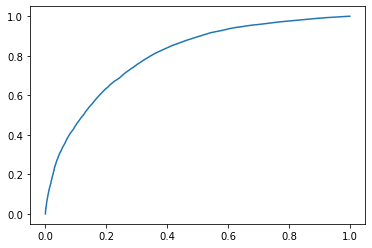

In [75]:
y_pred_proba = lgbm_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [80]:
# Check overfitting
y_train_pred = lgbm_model.predict(X_train_trans)
confusion_matrix(y_train, y_train_pred)

array([[ 29410,  41096],
       [ 14012, 187696]], dtype=int64)

In [81]:
accuracy_score(y_train, y_train_pred)

0.7975563343545886

### CatBoostClassifier

In [91]:
from catboost import CatBoostClassifier

In [107]:
cb_model = CatBoostClassifier(iterations = 5000)

In [ ]:
parameters = {
    'learning_rate': np.arange(0.1, 1, 0.1),
    'depth':np.arange(2, 5, 1),
    'iterations': np.arange(1000, 5000, 1000)}

gs = GridSearchCV(cb_model, parameters)
gs.fit(X_eval_trans, y_eval, verbose=False)

In [ ]:
gs.best_params_, gs.best_score_

In [ ]:
best_params = gs.best_params_
#best_params = 

In [108]:
#cb_model.set_params(**best_params)
cb_model.fit(X_train_trans, y_train)

Learning rate set to 0.025804
0:	learn: 0.6790299	total: 120ms	remaining: 9m 58s
1:	learn: 0.6653533	total: 233ms	remaining: 9m 41s
2:	learn: 0.6529307	total: 319ms	remaining: 8m 51s
3:	learn: 0.6411610	total: 420ms	remaining: 8m 44s
4:	learn: 0.6301161	total: 524ms	remaining: 8m 43s
5:	learn: 0.6195760	total: 614ms	remaining: 8m 31s
6:	learn: 0.6098424	total: 704ms	remaining: 8m 22s
7:	learn: 0.6009292	total: 806ms	remaining: 8m 23s
8:	learn: 0.5922610	total: 887ms	remaining: 8m 11s
9:	learn: 0.5842343	total: 972ms	remaining: 8m 4s
10:	learn: 0.5769030	total: 1.07s	remaining: 8m 3s
11:	learn: 0.5699424	total: 1.18s	remaining: 8m 10s
12:	learn: 0.5637518	total: 1.28s	remaining: 8m 12s
13:	learn: 0.5578047	total: 1.4s	remaining: 8m 17s
14:	learn: 0.5523936	total: 1.5s	remaining: 8m 17s
15:	learn: 0.5469164	total: 1.61s	remaining: 8m 20s
16:	learn: 0.5416236	total: 1.72s	remaining: 8m 23s
17:	learn: 0.5366990	total: 1.84s	remaining: 8m 28s
18:	learn: 0.5322232	total: 1.96s	remaining: 8m 

In [136]:
y_test_pred = cb_model.predict(X_test_trans)

In [110]:
confusion_matrix(y_test, y_test_pred)

array([[ 7835,  9945],
       [ 3831, 46443]], dtype=int64)

In [111]:
accuracy_score(y_test, y_test_pred)

0.7975725159432215

0.8061181552986149

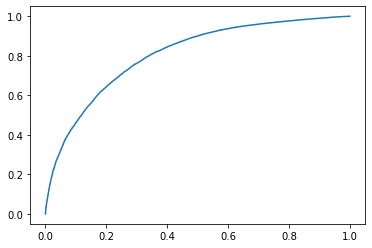

In [112]:
y_pred_proba = cb_model.predict_proba(X_test_trans)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
 
plt.plot(fpr,tpr);
auc

In [166]:
data_results = pd.concat([X_test.reset_index(drop=True),y_test.reset_index(drop = True),pd.Series(y_test_pred)], axis=1)

In [162]:
data_results[data_results['TARGET']!=data_results[0]]

,PAR_C,SEX,EDA,CS_P13_1,CS_P16,CS_P17,N_HIJ,E_CON,UR,CAMPO,ENT_ORIGEN,y_pred,TARGET,0
15,301,1,24,7,2,1,0,6,1,2,1,NaN,1,0
23,301,1,29,7,1,2,0,6,1,3,1,NaN,0,1
25,301,2,39,8,1,2,1,5,1,3,0,NaN,0,1
30,201,2,39,7,1,2,2,5,2,4,1,NaN,0,1
43,301,1,28,7,1,2,0,6,1,5,1,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68026,301,1,22,7,2,1,0,6,1,3,0,NaN,1,0
68033,301,1,21,7,2,1,0,6,1,5,1,1.0,1,0
68035,201,2,40,7,2,2,2,5,1,3,0,NaN,0,1
68046,301,1,21,7,1,2,0,6,1,3,1,NaN,0,1
